#**Projeto: Pipeline de Dados do Telegram**


## 1. Sobre o Projeto

O projeto tem como objetivo desenvolver um pipeline de dados para um grupo no Telegram. Um bot será responsável por coletar todas as mensagens e, por meio da API, enviá-las para a AWS. Os dados serão então processados e transformados para visualização.

### 1.2 Chatbot

Um chatbot é um software desenvolvido para interagir com usuários por meio de conversas automatizadas em plataformas de mensagens. Uma de suas aplicações mais comuns é no atendimento ao cliente, onde auxilia na resolução de dúvidas e problemas frequentes, agilizando o suporte e reduzindo a necessidade de intervenção humana.

### 1.3 Telegram

O Telegram é uma plataforma de mensagens instantâneas gratuita (freeware) e, em grande parte, de código aberto (open source). É amplamente popular entre desenvolvedores por ter sido pioneiro na implementação de chatbots, permitindo a criação de diversas automações e integrações.

### 1.4 Arquitetura

Foi desenvolvido um pipeline de dados capaz de ingerir, processar, armazenar e disponibilizar mensagens de um grupo do Telegram, permitindo que profissionais de dados realizem análises. A arquitetura proposta é dividida em duas partes: a transacional, no Telegram, onde os dados são gerados, e a analítica, na Amazon Web Services (AWS), onde os dados são processados e analisados.

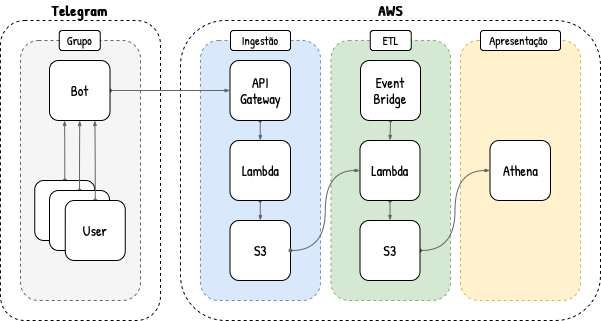

## 2. Coleta de Dados

### 2.1 Fonte dos Dados

O **Telegram** representa a fonte onde ocorre a transação dos dados. Nesta etapa, um bot é criado por meio do *BotFather* (ferramenta oficial do Telegram para gerenciar bots). Em seguida, um grupo é criado no Telegram, e o bot é adicionado como administrador. A partir disso, ele passa a capturar todas as mensagens enviadas no grupo, que podem ser acessadas por meio da API oficial do Telegram. Documentação neste [link](https://core.telegram.org/bots/api)

Codigo para coletar a api do bot

In [ ]:
from getpass import getpass

token = getpass()

A url base que é comum a todos os métodos da API.

In [ ]:
import json

base_url = f'https://api.telegram.org/bot{token}'

* getMe

Metodo que retorna informações sobre o bot

In [ ]:
import requests

response = requests.get(url=f'{base_url}/getMe')

print(json.dumps(json.loads(response.text), indent=2))

* getUpdates

que vai retornar essas mensagens enviadas pelo bot

In [ ]:
response = requests.get(url=f'{base_url}/getUpdates')

print(json.dumps(json.loads(response.text), indent=2))

Obs: O Jason criado nesse codigo, será necessário para configuração do codigo no Lambda

### 2.2 Métodos de Coleta

#### **2.2.1 AWS | Ingestão**

A etapa de ingestão é responsável por transferir os dados transacionais para ambientes analíticos. Em geral, os dados ingeridos são armazenados no formato mais próximo do original, sem transformações em seu conteúdo ou estrutura (schema). Por exemplo, dados de uma API web baseada no padrão REST (Representational State Transfer) são entregues e armazenados no formato JSON.

Manter os dados em seu formato original traz diversas vantagens, como a possibilidade de reprocessamento futuro. A ingestão pode ser realizada de duas formas:

Batch: blocos de dados são ingeridos em intervalos regulares, geralmente na escala de horas ou dias.

Streaming: os dados são ingeridos em tempo real, conforme são produzidos e disponibilizados.

No projeto, as mensagens capturadas pelo bot podem ser ingeridas através da API web de bots do Telegram, sendo fornecidas no formato JSON. Como o Telegram retém as mensagens por apenas 24 horas, a ingestão via streaming é a mais adequada. Para viabilizar esse tipo de ingestão, utilizamos um webhook, que redireciona automaticamente as mensagens para outra API web.

Para isso, é necessário um serviço da AWS que forneça uma API web capaz de receber esses dados redirecionados. O AWS API Gateway é a solução ideal, pois permite a integração com outros serviços da AWS. Assim, os dados recebidos pelo API Gateway serão direcionados ao AWS Lambda, que por sua vez os armazenará no formato original (JSON) em um bucket do AWS S3.

Esse modelo segue o conceito de arquitetura orientada a eventos (event-driven), onde sistemas reagem dinamicamente à chegada de novos dados.

Passos necessários:
* Criar um bucket no AWS S3;

* Criar uma função no AWS Lambda;

* Criar uma API web no AWS API Gateway;

* Configurar o webhook da API de bots do Telegram.

#### **2.2.2 AWS S3** image.png

Na etapa de ingestão, o AWS S3 atua como um armazenamento passivo para as mensagens captadas pelo bot do Telegram, mantendo-as em seu formato original (JSON). Para isso, basta a criação de um bucket, que servirá como repositório dos dados brutos. Como padrão de nomenclatura, adicionaremos o sufixo "-raw" ao nome do bucket, mantendo essa convenção para todos os serviços dessa camada.

Nota: Um data lake é um repositório projetado para armazenar grandes volumes de dados, organizados em diferentes zonas conforme seu nível de processamento. As nomenclaturas podem variar, mas as mais comuns incluem raw e enriched, ou a divisão em bronze, silver e gold, representando respectivamente os dados brutos, processados e prontos para consumo analítico.

#### **2.2.2 AWS Lambda** image.png

Na etapa de ingestão, o AWS Lambda é responsável por persistir as mensagens captadas pelo bot do Telegram em um bucket do AWS S3. Para isso, criaremos uma função que segue o seguinte fluxo:

Recebe a mensagem por meio do parâmetro event;

Verifica se a mensagem foi originada no grupo correto do Telegram;

Persiste a mensagem no formato JSON no bucket do AWS S3;

Retorna uma resposta de sucesso (código HTTP 200) à API de bots do Telegram.

Nota: No Telegram, restringimos a adição do bot a grupos, mas ainda é possível iniciar uma conversa em um chat privado.

Codigo da função lambda:

In [ ]:
import os
import json
import logging
from datetime import datetime, timezone

import boto3


def lambda_handler(event: dict, context: dict) -> dict:

  '''
  Recebe uma mensagens do Telegram via AWS API Gateway, verifica no
  seu conteúdo se foi produzida em um determinado grupo e a escreve,
  em seu formato original JSON, em um bucket do AWS S3.
  '''

  # vars de ambiente

  BUCKET = os.environ['AWS_S3_BUCKET']
  TELEGRAM_CHAT_ID = int(os.environ['TELEGRAM_CHAT_ID'])

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = datetime.now(tzinfo).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  filename = f'{timestamp}.json'

  # código principal

  client = boto3.client('s3')

  try:

    message = json.loads(event["body"])
    chat_id = message["message"]["chat"]["id"]

    if chat_id == TELEGRAM_CHAT_ID:

      with open(f"/tmp/{filename}", mode='w', encoding='utf8') as fp:
        json.dump(message, fp)

      client.upload_file(f'/tmp/{filename}', BUCKET, f'telegram/context_date={date}/{filename}')

  except Exception as exc:
      logging.error(msg=exc)
      return dict(statusCode="500")

  else:
      return dict(statusCode="200")

**Para que a função funcione corretamente, algumas configurações precisam ser realizadas.**


* **Variáveis de Ambiente**

O código requer a configuração de duas variáveis de ambiente: AWS_S3_BUCKET (com o nome do bucket do AWS S3) e TELEGRAM_CHAT_ID (com o ID do chat do grupo no Telegram). Para adicionar essas variáveis de ambiente a uma função do AWS Lambda, acesse Configurações -> Variáveis de Ambiente no console da função.

Nota: As variáveis de ambiente são uma excelente forma de armazenar informações sensíveis de maneira segura.

* **Permissões**

Além disso, é necessário conceder permissão de escrita no bucket do AWS S3 para a função do AWS Lambda, utilizando o AWS IAM.



#### **2.2.3 AWS API Gateway**  image.png

Na etapa de ingestão, o AWS API Gateway tem a função de receber as mensagens captadas pelo bot do Telegram, enviadas via webhook, e acionar uma função do AWS Lambda, passando o conteúdo da mensagem por meio do parâmetro event. Para isso, vamos criar uma API e configurá-la como gatilho para a função do AWS Lambda.

API Gateway > APIs

In [ ]:
aws_api_gateway_url = getpass()

#### **2.2.4 Telegram**


Vamos configurar o webhook para redirecionar as mensagens para a url do AWS API Gateway.

* **setWebhook**

O método setWebhook configura o redirecionamento das mensagens captadas pelo bot para o endereço web do paramametro url.

In [ ]:
response = requests.get(url=f'{base_url}/setWebhook?url={aws_api_gateway_url}')

print(json.dumps(json.loads(response.text), indent=2))

* **getWebhookInfo**

O método `getWebhookInfo` retorna as informações sobre o *webhook* configurado.

In [ ]:
response = requests.get(url=f'{base_url}/getWebhookInfo')

print(json.dumps(json.loads(response.text), indent=2))

## 3. Processamento dos Dados

### 3.1 ETL

A etapa de extração, transformação e carregamento (ETL – Extraction, Transformation and Load) é essencial para a manipulação de dados ingeridos a partir de sistemas transacionais, ou seja, já armazenados em camadas cruas (raw) de sistemas analíticos. O processo de ETL pode variar conforme a área de negócio, o volume, a variedade e a velocidade dos dados consumidos. No entanto, de modo geral, os dados brutos passam por um processo recorrente de data wrangling, no qual são limpos, deduplicados e transformados antes de serem armazenados com técnicas como particionamento, orientação a colunas e compressão. Esse tratamento permite que os dados estejam preparados para análises mais eficientes por profissionais da área.

No projeto, as mensagens coletadas diariamente serão armazenadas inicialmente na camada crua e, posteriormente, processadas em um único arquivo por dia. Esse arquivo será estruturado com orientação a colunas e compressão para otimizar consultas e armazenamento, sendo então persistido em uma camada enriquecida. Durante essa transformação, os dados também passarão por processos de data wrangling para garantir sua qualidade e padronização.

Para viabilizar esse fluxo, utilizaremos uma função AWS Lambda como motor de processamento e um bucket AWS S3 como repositório da camada enriquecida. Além disso, para garantir a execução automatizada e recorrente do processo, uma regra no AWS EventBridge será configurada para acionar a função diariamente.

#### **3.1.1 AWS S3** image.png

Na etapa de ETL, o AWS S3 tem a função de passivamente armazenar as mensagens processadas de um dia em um único arquivo no formato Parquet. Para tanto, basta a criação de um bucket.

#### **3.1.2 AWS Lambda** image.png

Na etapa de ETL, a função AWS Lambda será responsável por processar ativamente as mensagens captadas pelo bot do Telegram, que foram previamente armazenadas na camada crua (raw) em um bucket do AWS S3. Após o processamento, os dados serão transformados e armazenados na camada enriquecida, também em um bucket do AWS S3.

Para isso, a função será desenvolvida para operar da seguinte maneira:


A função AWS Lambda será desenvolvida para executar o seguinte fluxo de processamento:

1. **Listar os arquivos JSON**: Identificar todos os arquivos JSON de uma única partição na **camada crua** (*raw*) dentro do **bucket do AWS S3**.
2. **Processar cada arquivo**: Para cada arquivo listado:
   - **Fazer o download** do arquivo e carregar seu conteúdo.
   - **Executar a função de data wrangling** para limpeza, padronização e enriquecimento dos dados.
   - **Criar uma tabela PyArrow** a partir dos dados processados e concatená-la com as demais.
3. **Persistir os dados processados**:
   - Converter a tabela final para o formato **Parquet**, garantindo **orientação a colunas e compressão** para otimizar consultas e armazenamento.
   - Salvar o arquivo resultante na **camada enriquecida** (*enriched*) dentro do **bucket do AWS S3**.

Código da função:

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None

      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True

  except Exception as exc:
      logging.error(msg=exc)
      return False

O código da função de Data Wrangling:

In [ ]:
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

Obs: AWS_S3_BUCKET e AWS_S3_ENRICHED serão substituidos pelo nome do Bucket do S3 na configuração da variavel de ambiente do Lambda

* **Permissão**

Damos as devidas permissões do bucket do S3 para que ele tenha acesso a leitura e escrita para que a função funcione

Por fim, é importante destacar que a função utiliza o pacote PyArrow, que não está disponível no ambiente padrão do AWS Lambda, que possui poucos pacotes externos pré-instalados, como o boto3. Isso significa que, sem a adição do PyArrow, a execução da função falhará.

Para resolver esse problema, podemos adicionar pacotes externos ao ambiente do Lambda por meio de layers (camadas), que permitem o upload dos pacotes diretamente na plataforma ou via bucket do AWS S3. Optaremos pela segunda abordagem, seguindo os seguintes passos:

* Criar um bucket no AWS S3.

* Fazer o upload do código do pacote Python PyArrow [link](https://github.com/awslabs/aws-data-wrangler/releases).

* Criar o layer no AWS Lambda e associá-lo à função.

#### **3.1.3 AWS Event Bridge** image.png

Nesta etapa, um evento é configurado na plataforma para coletar as mensagens todos os dias à meia-noite e armazená-las no bucket dos arquivos raw. Em seguida, a função Lambda é responsável por transformar os arquivos em Parquet, formatando-os adequadamente para que possam ser processados no AWS Athena.

## 4. Apresentação

Nesta etapa, são gerados os arquivos que os usuários utilizarão para realizar suas análises. Resumidamente, o arquivo final é no formato .parquet, que pode ser facilmente utilizado para gerar gráficos e insights por meio de ferramentas como SQL (Athena).

### 4.1. AWS Athena image.png

Na etapa de apresentação, o AWS Athena desempenha o papel de fornecer os dados por meio de uma interface SQL para os usuários do sistema analítico. Para criar essa interface, basta criar uma tabela externa sobre os dados armazenados na camada mais refinada da arquitetura: a camada enriquecida.

Função para criar uma tabela no Athena:

```sql
CREATE EXTERNAL TABLE `telegram`(
  `message_id` bigint,
  `user_id` bigint,
  `user_is_bot` boolean,
  `user_first_name` string,
  `chat_id` bigint,
  `chat_type` string,
  `text` string,
  `date` bigint)
PARTITIONED BY (
  `context_date` date)
ROW FORMAT SERDE
  'org.apache.hadoop.hive.ql.io.parquet.serde.ParquetHiveSerDe'
STORED AS INPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetInputFormat'
OUTPUTFORMAT
  'org.apache.hadoop.hive.ql.io.parquet.MapredParquetOutputFormat'
LOCATION
  's3://<bucket-enriquecido>/'
```

Necessário realizar o Repair table:

```sql
MSCK REPAIR TABLE `telegram`;
```

Função para consultar as 10 primeiras linhas:

```sql
SELECT * FROM `telegram` LIMIT 10;
```

#### **4.1.1 Analytics**

Alguns códigos para realizar consultas na tabela:

* Quantidade de mensagens por dia:

```sql
SELECT
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY context_date
ORDER BY context_date DESC
```

* Quantidade de mensagens por usuário por dia:

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  count(1) AS "message_amount"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

* Média do tamanho das mensagens por usuário e por dia:

```sql
SELECT
  user_id,
  user_first_name,
  context_date,
  CAST(AVG(length(text)) AS INT) AS "average_message_length"
FROM "telegram"
GROUP BY
  user_id,
  user_first_name,
  context_date
ORDER BY context_date DESC
```

* Quantidade de mensagens por hora, por dia da semana e por número da semana:

```sql
WITH
parsed_date_cte AS (
    SELECT
        *,
        CAST(date_format(from_unixtime("date"),'%Y-%m-%d %H:%i:%s') AS timestamp) AS parsed_date
    FROM "telegram"
),
hour_week_cte AS (
    SELECT
        *,
        EXTRACT(hour FROM parsed_date) AS parsed_date_hour,
        EXTRACT(dow FROM parsed_date) AS parsed_date_weekday,
        EXTRACT(week FROM parsed_date) AS parsed_date_weeknum
    FROM parsed_date_cte
)
SELECT
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum,
    count(1) AS "message_amount"
FROM hour_week_cte
GROUP BY
    parsed_date_hour,
    parsed_date_weekday,
    parsed_date_weeknum
ORDER BY
    parsed_date_weeknum,
    parsed_date_weekday
```

-----------------------------------------------------------
## 5. Análise exploratória dos dados

Realizei alguns testes utilizando o mensageiro Telegram, e enviei algumas mensagens, que foram captadas por todo o percurso já mostrado no projeto.

Query 1 - Aqui ele mostra um grafico da quantidade de mensagens por dia.

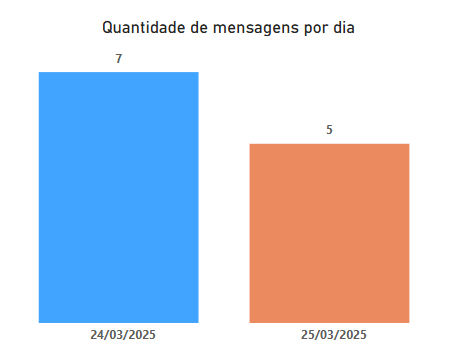

Query 2 - Aqui o grafico apresenta os usuários e a porcentagem de mensagens por dia, como no caso só eu mandei mensagem como teste, ele só vai mostrar meu nome.

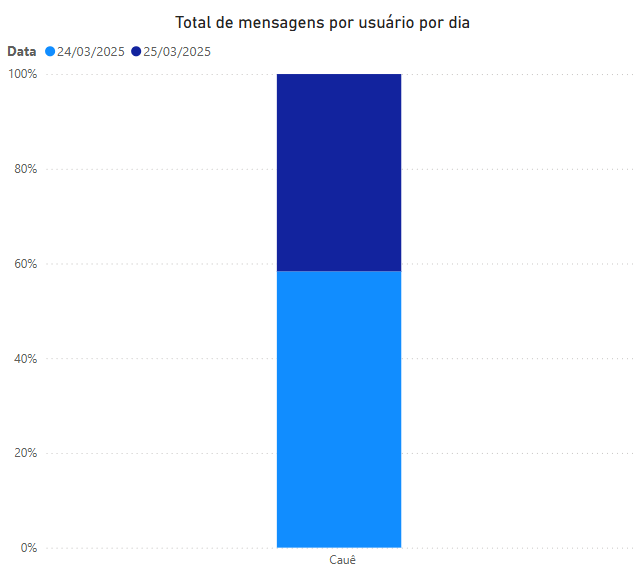

Query 3 - E por fim, um grafico mostrando a quantidade de mensagens enviadas por horário, assim o responsavel pode analisar qual horario recebe mais mensagem (demanda)

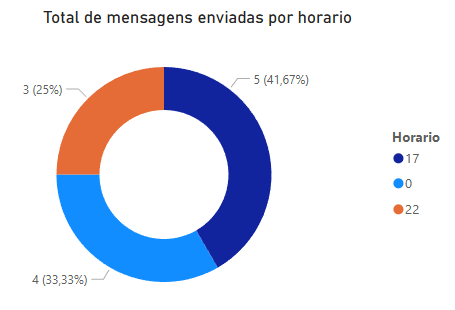

E por fim, o intuito deste projeto foi demonstrar todo o processo de um pipeline de dados, desde a coleta até a transformação e armazenamento das informações. Embora haja diversas possibilidades de aprimoramento, como a captura de imagens, áudios e vídeos, essas funcionalidades não foram implementadas, pois o foco principal foi a captação e análise de mensagens.